Everyone just subtracts the mean and divides by the standard deviation of the whole dataset (okay not everyone, but for e.g. many people that do Imagenet training). Is the skin dataset large enough to also do this or do we need to calculate the mean and std of every training fold (which is not fun to program, honestly...). To find out, this notebook is written.

In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd
from glob import glob
import numpy as np
from tqdm import trange, tqdm
from PIL import Image
import matplotlib.pyplot as plt
from typing import Optional

In [4]:
def build_stack():
    csv_targets = pd.read_csv('../data/z-stacks/logistic_targets.csv')
    # csv_targets = csv_targets.drop([1, 10])[["index"]].to_numpy() # drop index 7 and 16 (at row 1 and 10), because their images are too small.
    csv_targets = csv_targets[["index"]].to_numpy()

    image_paths = glob(f"../data/preprocessed/resized/500/z-stacks/**/*.bmp")
    cleaned_image_paths = []
    for path in image_paths:
        try:
            if int(path.split('/')[6]) not in csv_targets:
                continue
            cleaned_image_paths.append(path)
        except:
            continue

    groups = []
    stack = np.zeros((len(cleaned_image_paths), 500*500))
    for i, path in enumerate(tqdm(cleaned_image_paths, desc="Building stack")):
        img = Image.open(path)
        img_data = np.asarray(img)
        stack[i, :] = img_data.flatten()
        groups.append(int(path.split('/')[-2]))


    return stack, groups

In [5]:
def create_train_split(stack: np.ndarray, percentage: float, seed: int, groups: Optional[list[int]] = None) -> np.ndarray[int]:
    train_size = int(stack.shape[0] * percentage)
    train_split = train_test_split(np.arange(stack.shape[0]), train_size=train_size, random_state=seed, stratify=groups)[0]
    return train_split

In [6]:
def compute_mean_std_of_subset(stack: np.ndarray, idx: Optional[list[int]] = None):    
    """Compute the mean and standard deviation of a subset in the stack.

    Args:
        stack: numpy array WHI (width, height, image).
        idx: list of numbers to subsample the stack.
    """
    try:
        mean = np.mean(stack[idx, :])
        std = np.std(stack[idx, :])
    except IndexError:
        mean = np.mean(stack)
        std = np.std(stack)

    return mean, std

In [7]:
def combine_func(stack, groups, percentage, seed):

    idx = create_train_split(stack, percentage, seed, groups)
    mean, std = compute_mean_std_of_subset(stack, idx)


    return mean, std

In [8]:
stack, groups = build_stack()

num_samples = 100

df = []
for seed in trange(num_samples, desc="Drawing samples"):
    # Because we take 80% of the training/validation set, which is 80% of the total set.
    mean, std = combine_func(stack, groups, 0.8*0.8, seed)
    df.append((mean, std))


Drawing samples: 100%|██████████| 100/100 [06:46<00:00,  4.07s/it]


In [9]:
data = np.asarray(df)
np.save('outputs/stats/mean-std.npy', data)

Whole stack mean=97.62348310672854 and std=66.14201631693666.


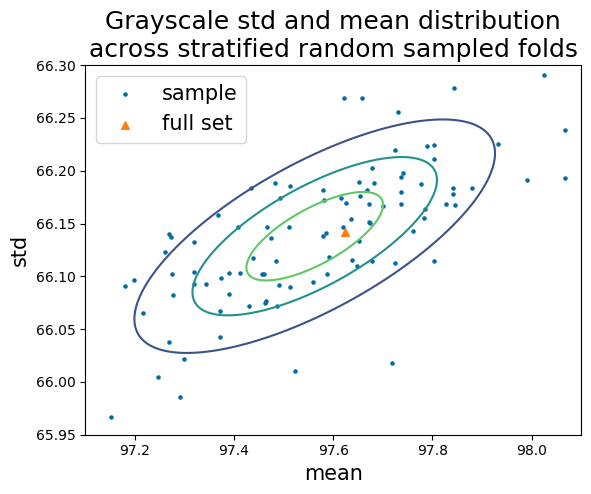

In [26]:
from scipy.stats import multivariate_normal
plt.style.use('tableau-colorblind10')
xmin, ymin, xmax, ymax = *np.min(data, axis=0), *np.max(data, axis=0)
x, y = np.mgrid[xmin:xmax:.001, ymin:ymax:.001]
pos = np.dstack((x, y))
rv = multivariate_normal(np.mean(data, axis=0), np.cov(data, rowvar=0))
stack_mean, stack_std = compute_mean_std_of_subset(stack)
print(f"Whole stack mean={stack_mean} and std={stack_std}.")

plt.scatter(data[:, 0], data[:, 1], s=20, label='sample', marker='.')
plt.scatter(stack_mean, stack_std, s=30, label='full set', marker='^')
plt.ylabel("std", fontsize=15)
plt.xlabel("mean", fontsize=15)
plt.title("Grayscale std and mean distribution\nacross stratified random sampled folds", fontsize=18)
plt.legend(fontsize=15)
plt.ylim([65.95, 66.3])
plt.xlim([97.1, 98.1])

plt.contour(x, y, rv.pdf(pos), levels=3)

plt.show()

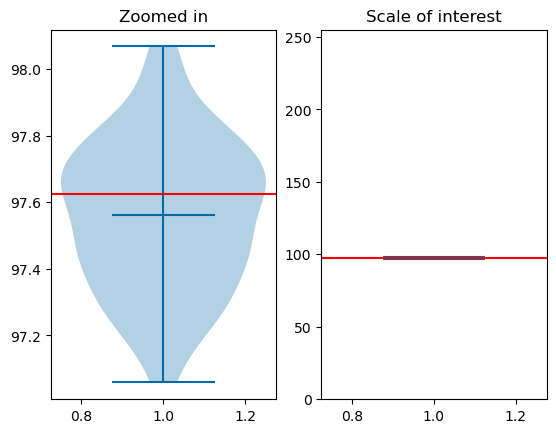

In [11]:
ax1 = plt.subplot(121)
ax1.violinplot(data[:, 0], showmeans=True)
ax1.axhline(stack_mean, c='red')
ax1.set_title("Zoomed in")

ax2 = plt.subplot(122)
ax2.violinplot(data[:, 0], showmeans=True)
ax2.axhline(stack_mean, c='red')
ax2.set_ylim([0, 255])
ax2.set_title("Scale of interest")

plt.show()


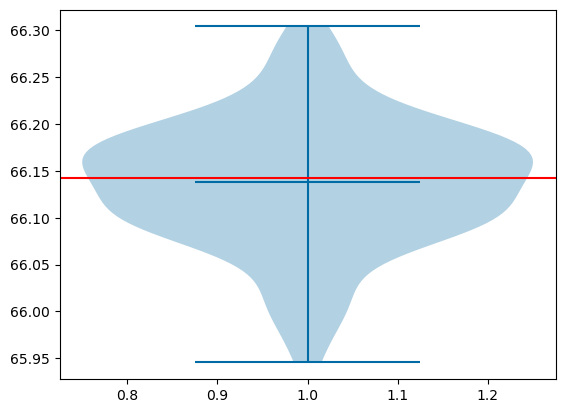

In [12]:
plt.violinplot(data[:, 1], showmeans=True)
plt.axhline(stack_std, c='red')
plt.show()